# Multi-way Interactions

This tutorial constructs hypergraphs from 2D and pairwise data using methods of multi-correlation. A multi-correlation is a function that measures the relationships between three or more variables. Based on the strength of these relationships between sets of variables, hyperedges may be defined and used to construct a hypergraph. This demo will walk through each of these steps using HAT [1].

## Multi-way Relationship Measures
Let $D\in R^{m\times n}$ be a 2D data matrix with $m$ measurements taken on $n$ variables, and each variable represents a vertex in the hypergraph. Then the correlation matrix is defined $R=cor(D)\in R^{m\times m}$. An individual entry $R_{i,j}$ is the pairwise relationship between the $i$th and $j$th random variables in $D.$ To determine the relationship between more than two variables, multi-correlation matrices examine minors or submatrices of $R$, which are denoted $R'$. The below three measures are implemented in HAT.

### Drezner
In "Multirelation—a correlation among more than two variables," Zvi Drezner proposes a muli-correlation measure based on the linear fit of data [2]. Minors of are considered, and the linear fit between the random variables is determined according to the measure
$$1-\lambda(R'),$$
where $R'$ denotes a minor of $R$ and $\lambda$ represents the smallest eigenvalue of the matrix.
### Wang and Zheng
In "Measures of correlation for multiple variables," Jianji Wang and Nanning Zheng define a multi-correlation measure according to the equation [3]:
$$(1-det(R'))^{0.5}$$
### Taylor
In "A multi-way correlation coefficient," Benjamin Taylor defines a multi-correlation measure according to the equation [4]:
$$\frac{1}{\sqrt{k}}std(\lambda_1,\dots,\lambda_k)$$
where $k$ is the size of the minor $R'$ and the values $\lambda_1,\dots,\lambda_k$ are the eigenvalues of $R'$.

Each of the above 3 measures is implemented by HAT. In Example 1, the step-by-step process of computing the multi-way relationships is shown, and in Example 2, these methods are applied to construct a hypergraph from pairwise data using HAT.

In [1]:
# !pip install --upgrade pip
# !pip install HypergraphAnalysisToolbox

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
import HAT

## Example 1
This example walks through analyzing the minors of a correlation matrix. A small data matrix is given, all minors of size  are extracted, and the multicorrelation functions are applied to each minor. This example doesn't use HAT but instead shows how HAT works. In this cell, a data matrix  is created for a 4 variables with 4 measurements taken on each.

In this cell, a data matrix  is created for a 4 variables with 4 measurements taken on each. The built-in MATLAB function corrcoef computes the correlation matrix 

In [3]:
# Set matrix D
D = np.array([[0.4218,    0.6557,    0.6787,    0.6555],
              [0.9157,    0.0357,    0.7577,    0.1712],
              [0.7922,    0.8491,    0.7431,    0.7060],
              [0.9595,    0.9340,    0.3922,    0.0318]])
# Get correlation matrix R
R = np.corrcoef(D)
print(R)

[[ 1.         -0.62118416 -0.23268933 -0.56996902]
 [-0.62118416  1.         -0.16273378  0.21515876]
 [-0.23268933 -0.16273378  1.          0.91619412]
 [-0.56996902  0.21515876  0.91619412  1.        ]]


Extracting minors or submatrices of a matrix in Python is as simple as taking the row and column slices of the original matrix. For the matrix  above, the minor on variables 0, 1, and 2 is the submatrix:

In [4]:
# Manually create minor R123
R123 = np.array([[0.4218,    0.6557,    0.6787],
                 [0.9157,    0.0357,    0.7577],
                 [0.7922,    0.8491,    0.7431]])
# Slices to get minor R123
R123 = R[np.ix_([0,1,2], [0,1,2])]
print(R123)

[[ 1.         -0.62118416 -0.23268933]
 [-0.62118416  1.         -0.16273378]
 [-0.23268933 -0.16273378  1.        ]]


To consider all possible way interactions among $n$ variables, the command `itertools.combinations` enumerates all possible indices that are used to extract minors of $R$. In the code below, all 3-way interactions are generated and listed as a row of the `idxs` matrix.

In [5]:
n = 4
k = 3
idxs = np.array(list(itertools.combinations(range(len(R)), k)))
print(idxs)

[[0 1 2]
 [0 1 3]
 [0 2 3]
 [1 2 3]]


To compute each multicorrelation measure for $k-$way interactions among $n$ variables, we can iterate over each set of indices used to extract minors of $R$. Then, for each minor, the multcorrelation is computed according to one of the measures given above [2,3,4].

In [6]:
M = np.zeros(len(idxs),)
mtype = 'Drezner'
for i in range(len(idxs)):
    minor = R[np.ix_(idxs[i,:], idxs[i,:])]
    if mtype == 'Drezner':
        w, _ = np.linalg.eigh(minor)
        M[i] = 1 - w[0]
    elif mtype == 'Wang':
        M[i] = pow((1 - np.linalg.det(minor)), 0.5)
    elif mtype == 'Taylor':
        w, _ = np.linalg.eigh(minor)
        M[i] = (1/np.sqrt(k)) * np.std(w)
print(M)

[0.72873333 0.74293639 0.98585613 0.98848037]


The process detailed in Example 1 is automatically performed by HAT when the data matrix $D$ and order of the interactions $k$ is provided. Example 2 demonstrates how to perform these operations quickly with HAT.

# Example 2: Zachary’s Karate Club

In this example, multi-way correlation measures are utilized to identify high-order interactions in pairwise data. The Karate network is a social network of 34 individuals belonging to the same Karate club at a US university [5] and is canonical to network science. This data is built-in to `HAT` from `networkx` and can be accessed via the `HAT.load` method.

In [7]:
G = HAT.load('Karate')
A = np.array(nx.adjacency_matrix(G).todense())
print(G)

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


The Karate network may be visualized as either an adjacency matrix or a pairwise graph.

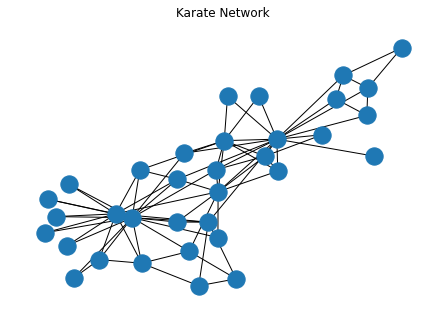

In [8]:
nx.draw(G)
plt.title('Karate Network')
plt.show()

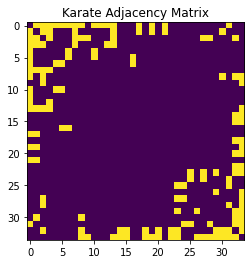

In [9]:
plt.imshow(A, interpolation='nearest')
plt.title('Karate Adjacency Matrix')
plt.show()

To compute multi-way interactions with `HAT`, the data, order of the interaction and method (i.e. Drezner, Taylor, Wang) are passed to the method `HAT.multicorrelations`. The function then returns 2 vectors `[M, idxs]`, where `M` contains multi-way measurements and `idxs` contains the indices of `A` that correspond the the multicorrelation values in `M`. In this case, the pairwise adjacency matrix is utilized as the general 2D data matrix.

In [10]:
k = 3;
[M, idxs] = HAT.multicorrelations(A, k, 'Wang');

By default, `HAT.multicorrelations` computes the multi-way measurements on all $\binom{n}{k}$ possible sets of random variables from $D$. This presents a computational challenge as $n$ or $k$ increase. To elimintate this challenge, a 4th argument idxs may be passed to this function where idxs is the same format as when it is returned but instead it may be presepcified as the list of variables for multi-correlations to compute. The synatax of this is: `[M, ~] = HAT.multicorrelations(D, k, 'type', idxs)`, where the type is either 'Drezner', 'Taylor', or 'Wang'.

Given a set of multi-way measurements, the aim is to construct a hypergraph using HAT where high multi-correlations indicate the presence of a hyperedge. Below, the histogram of the multicorrelation scores is plotted.

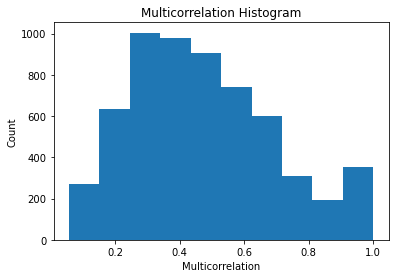

In [11]:
plt.hist(M)
plt.title('Multicorrelation Histogram')
plt.xlabel('Multicorrelation')
plt.ylabel('Count')
plt.show()

There are several methods for determining which multicorrelations should represent a hyperedge. The simplest method is to set a minimum threshold `thresh` such that all multicorrelations in `M` that are greater than `thresh` indicate the presence of a hyperedge. Additional methods of setting a threshold for the multicorrelation to indicate a hyperedge could exploite hypergraph properties such as adding edges with the highest multi-correlation until the hypergraph is fully connected, achieves a certain density, or has another desiarable property.

In this cell, a threshold `thresh` is set as the median value of `M` and the set of indices with multicorrelations larger than thresh are extracted from the `idxs` variable.

In [12]:
thresh = np.median(M)
m = np.where(M > thresh)
hyperedges = idxs[m, :][0]

Given the set of hyperedges, these must be transformed to an incidence matrix in order to construct a hypergraph. This is done with the function below.

In [13]:
IM = HAT.hyperedges2IM(hyperedges)

Given the incidence matrix a hypergraph representation of the Karate network may finally be constructed.

In [14]:
HG = HAT.Hypergraph(IM)

Given the incidence matrix a hypergraph representation of the Karate network may finally be constructed.

## References

[1] Joshua Pickard, Can Chen, Rahmy Salman, Cooper Stansbury, Sion Kim, Amit Surana, and Indika Rajapakse. "Hypergraph Analysis Toolbox for Chromosome Conformation."

[2] Zvi Drezner. Multirelation—a correlation among more than two variables. Computational Statistics & Data Analysis, 19(3):283–292, 1995.

[3] Jianji Wang and Nanning Zheng. Measures of correlation for multiple variables. arXiv preprint arXiv:1401.4827, 2014.

[4] Benjamin M Taylor. A multi-way correlation coefficient. arXiv preprint arXiv:2003.02561, 2020.

[5] W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977)
There are several methods for determining which multicorrelations should represent a hyperedge. The simplest method is to set a minimum threshold thresh such that all multicorrelations in M that are greater than thresh indicate the presence of a hyperedge. Additional methods of setting a threshold for the multicorrelation to indicate a hyperedge could exploite hypergraph properties such as adding edges with the highest multi-correlation until the hypergraph is fully connected, achieves a certain density, or has another desiarable property.
